<a href="https://colab.research.google.com/github/jajapuramshivasai/QML-Molecular-Classification/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA) for Graph Classification Datasets

This notebook performs comprehensive EDA on the following TU-Dortmund graph classification datasets:

- **AIDS**: HIV activity screening (2000 compounds)
- **PROTEINS**: Enzyme classification (1113 proteins)
- **NCI1**: Anti-cancer activity (4110 compounds)
- **PTC-MR**: Carcinogenicity prediction (344 compounds)
- **MUTAG**: Mutagenicity prediction (188 compounds)

## Overview

For each dataset, we will:
1. **Load** the graphs and labels.
2. **Analyze** statistics (graph sizes, class distribution, node labels).
3. **Visualize** dataset statistics (histograms for nodes/edges/density, etc.).
4. **Plot** sample graphs from each class (2 samples per class).

This uses NetworkX for graph handling and Matplotlib/Seaborn for visualization.

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install -q networkx numpy scikit-learn matplotlib seaborn requests tqdm

In [2]:
import os
import sys
import math
import warnings
from collections import Counter
from typing import List

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All imports successful!")

✓ All imports successful!


## 2. Data Loading Module

In [3]:
class TUDatasetLoader:
    """Load graph classification datasets from TU Dortmund repository"""

    def __init__(self, data_dir: str = "./datasets"):
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)
        self.base_url = "https://www.chrsmrrs.com/graphkerneldatasets"

    def download_dataset(self, dataset_name: str):
        """Download and extract dataset"""
        url = f"{self.base_url}/{dataset_name}.zip"
        dataset_path = os.path.join(self.data_dir, dataset_name)

        if os.path.exists(dataset_path):
            print(f"Dataset {dataset_name} already exists")
            return dataset_path

        print(f"Downloading {dataset_name}...")
        try:
            response = requests.get(url, timeout=120)
            response.raise_for_status()

            import zipfile
            import io
            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                z.extractall(self.data_dir)

            print(f"✓ {dataset_name} downloaded and extracted")
            return dataset_path
        except Exception as e:
            print(f"✗ Error downloading {dataset_name}: {e}")
            return None

    def load_graphs(self, dataset_name: str):
        """Load graphs from dataset files"""
        dataset_path = self.download_dataset(dataset_name)
        if dataset_path is None:
            return None, None

        dataset_path = os.path.join(self.data_dir, dataset_name)

        try:
            with open(os.path.join(dataset_path, f"{dataset_name}_A.txt")) as f:
                edges = [tuple(map(int, line.strip().split(','))) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_graph_indicator.txt")) as f:
                graph_indicator = [int(line.strip()) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_node_labels.txt")) as f:
                node_labels = [int(line.strip()) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_graph_labels.txt")) as f:
                labels = [int(line.strip()) for line in f if line.strip()]

            # Convert labels to binary (0/1)
            unique_labels = sorted(set(labels))
            label_map = {old: new for new, old in enumerate(unique_labels)}
            labels = [label_map[lab] for lab in labels]

            # Build graphs
            num_graphs = max(graph_indicator)
            graphs = [nx.Graph() for _ in range(num_graphs)]

            # Map nodes to graphs
            node_map = {}
            for idx, g_id in enumerate(graph_indicator, 1):
                node_map.setdefault(g_id, []).append(idx)

            # Add nodes with labels
            for g_id in range(1, num_graphs + 1):
                global_nodes = node_map.get(g_id, [])
                mapping = {gn: ln for ln, gn in enumerate(global_nodes)}
                for gn in global_nodes:
                    graphs[g_id - 1].add_node(mapping[gn], label=node_labels[gn - 1])

            # Add edges
            for u, v in edges:
                gu = graph_indicator[u - 1]
                if gu == graph_indicator[v - 1]:
                    local_nodes = node_map[gu]
                    local_map = {gn: ln for ln, gn in enumerate(local_nodes)}
                    graphs[gu - 1].add_edge(local_map[u], local_map[v])

            print(f"✓ Loaded {len(graphs)} graphs from {dataset_name}")
            print(f"  Class distribution: {Counter(labels)}")
            return graphs, labels

        except Exception as e:
            print(f"✗ Error loading {dataset_name}: {e}")
            return None, None

# Initialize loader
loader = TUDatasetLoader()
print("✓ Data loader initialized")

✓ Data loader initialized


## 3. Dataset Analysis and Visualization Functions

In [4]:
def analyze_dataset(graphs: List[nx.Graph], labels: List[int], dataset_name: str = ""):
    """Comprehensive dataset analysis"""
    n_nodes = [G.number_of_nodes() for G in graphs]
    n_edges = [G.number_of_edges() for G in graphs]
    density = [nx.density(G) if G.number_of_nodes() > 0 else 0 for G in graphs]

    print("="*70)
    print(f"DATASET STATISTICS: {dataset_name}")
    print("="*70)
    print(f"Number of graphs: {len(graphs)}")
    print(f"Class distribution: {Counter(labels)}")
    print(f"\nGraph size statistics:")
    print(f"  Nodes - Mean: {np.mean(n_nodes):.2f}, Std: {np.std(n_nodes):.2f}, Min: {np.min(n_nodes)}, Max: {np.max(n_nodes)}")
    print(f"  Edges - Mean: {np.mean(n_edges):.2f}, Std: {np.std(n_edges):.2f}, Min: {np.min(n_edges)}, Max: {np.max(n_edges)}")
    print(f"  Density - Mean: {np.mean(density):.3f}, Std: {np.std(density):.3f}")

    # Label distribution
    all_labels = [G.nodes[n].get('label', 0) for G in graphs for n in G.nodes() if G.number_of_nodes() > 0]
    if all_labels:
        label_dist = Counter(all_labels)
        print(f"\nNode label distribution: {dict(sorted(label_dist.items()))}")
        print(f"Number of unique node labels: {len(label_dist)}")
    print("="*70 + "\n")

def visualize_sample_graphs(graphs: List[nx.Graph], labels: List[int], n_samples: int = 2, dataset_name: str = ""):
    """Visualize sample graphs from each class"""
    atom_map = {
        0: 'C', 1: 'O', 2: 'N', 3: 'Cl', 4: 'F', 5: 'S', 6: 'P', 7: 'Br', 8: 'I',
        9: 'Na', 10: 'K', 11: 'Li', 12: 'Ca', 13: 'Al', 14: 'Si', 15: 'B', 16: 'H'
    }

    unique_labels = sorted(set(labels))
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=(6*n_samples, 5*n_classes))

    if n_classes == 1:
        axes = np.array([axes])
    if n_samples == 1:
        axes = axes.reshape(-1, 1)

    for class_idx, class_label in enumerate(unique_labels):
        class_graphs = [i for i, label in enumerate(labels) if label == class_label]
        sample_indices = np.random.choice(class_graphs, min(n_samples, len(class_graphs)), replace=False)

        for sample_idx, graph_idx in enumerate(sample_indices):
            G = graphs[graph_idx]
            ax = axes[class_idx, sample_idx]

            if G.number_of_nodes() == 0:
                ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center', fontsize=14)
                ax.axis('off')
                continue

            node_labels_dict = {}
            for node in G.nodes():
                label_val = G.nodes[node].get('label', 0)
                node_labels_dict[node] = atom_map.get(label_val, str(label_val))

            pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(G.number_of_nodes()))
            node_color = 'lightcoral' if class_label == 1 else 'skyblue'

            nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.5, width=2)
            nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_color,
                                  node_size=500, alpha=0.9, edgecolors='black', linewidths=2)
            nx.draw_networkx_labels(G, pos, labels=node_labels_dict,
                                   font_size=10, font_weight='bold', ax=ax)

            ax.set_title(f"Class {class_label} - Graph {graph_idx}\n"
                        f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}",
                        fontsize=11, fontweight='bold')
            ax.axis('off')

    plt.suptitle(f'Sample Graphs from {dataset_name}', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def plot_dataset_statistics(graphs: List[nx.Graph], labels: List[int], dataset_name: str = ""):
    """Plot comprehensive dataset statistics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    n_nodes = [G.number_of_nodes() for G in graphs]
    axes[0, 0].hist(n_nodes, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Number of Nodes', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Node Count Distribution', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    n_edges = [G.number_of_edges() for G in graphs]
    axes[0, 1].hist(n_edges, bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Number of Edges', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Edge Count Distribution', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    density = [nx.density(G) if G.number_of_nodes() > 0 else 0 for G in graphs]
    axes[0, 2].hist(density, bins=30, color='seagreen', alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Graph Density', fontweight='bold')
    axes[0, 2].set_ylabel('Frequency', fontweight='bold')
    axes[0, 2].set_title('Density Distribution', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

    avg_degrees = [np.mean([d for _, d in G.degree()]) if G.number_of_nodes() > 0 else 0 for G in graphs]
    axes[1, 0].hist(avg_degrees, bins=30, color='mediumpurple', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Average Degree', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Average Degree Distribution', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    class_counts = Counter(labels)
    axes[1, 1].bar(class_counts.keys(), class_counts.values(), color='gold', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Class Label', fontweight='bold')
    axes[1, 1].set_ylabel('Count', fontweight='bold')
    axes[1, 1].set_title('Class Distribution', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    all_node_labels = [G.nodes[n].get('label', 0) for G in graphs for n in G.nodes() if G.number_of_nodes() > 0]
    if all_node_labels:
        label_counts = Counter(all_node_labels)
        top_labels = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:15])
        axes[1, 2].bar(range(len(top_labels)), list(top_labels.values()),
                      color='salmon', alpha=0.7, edgecolor='black')
        axes[1, 2].set_xticks(range(len(top_labels)))
        axes[1, 2].set_xticklabels(list(top_labels.keys()), rotation=45)
        axes[1, 2].set_xlabel('Node Label', fontweight='bold')
        axes[1, 2].set_ylabel('Count', fontweight='bold')
        axes[1, 2].set_title('Top 15 Node Labels', fontweight='bold')
        axes[1, 2].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'Dataset Statistics: {dataset_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Analysis and visualization functions defined")

✓ Analysis and visualization functions defined


## 4. Perform EDA on All Datasets

We load each dataset and run the analysis/visualization pipeline.


PROCESSING DATASET: MUTAG
✓ MUTAG downloaded and extracted
✓ Loaded 188 graphs from MUTAG
  Class distribution: Counter({1: 125, 0: 63})
DATASET STATISTICS: MUTAG
Number of graphs: 188
Class distribution: Counter({1: 125, 0: 63})

Graph size statistics:
  Nodes - Mean: 17.93, Std: 4.58, Min: 10, Max: 28
  Edges - Mean: 19.79, Std: 5.68, Min: 10, Max: 33
  Density - Mean: 0.138, Std: 0.035

Node label distribution: {0: 2395, 1: 345, 2: 593, 3: 12, 4: 1, 5: 23, 6: 2}
Number of unique node labels: 7



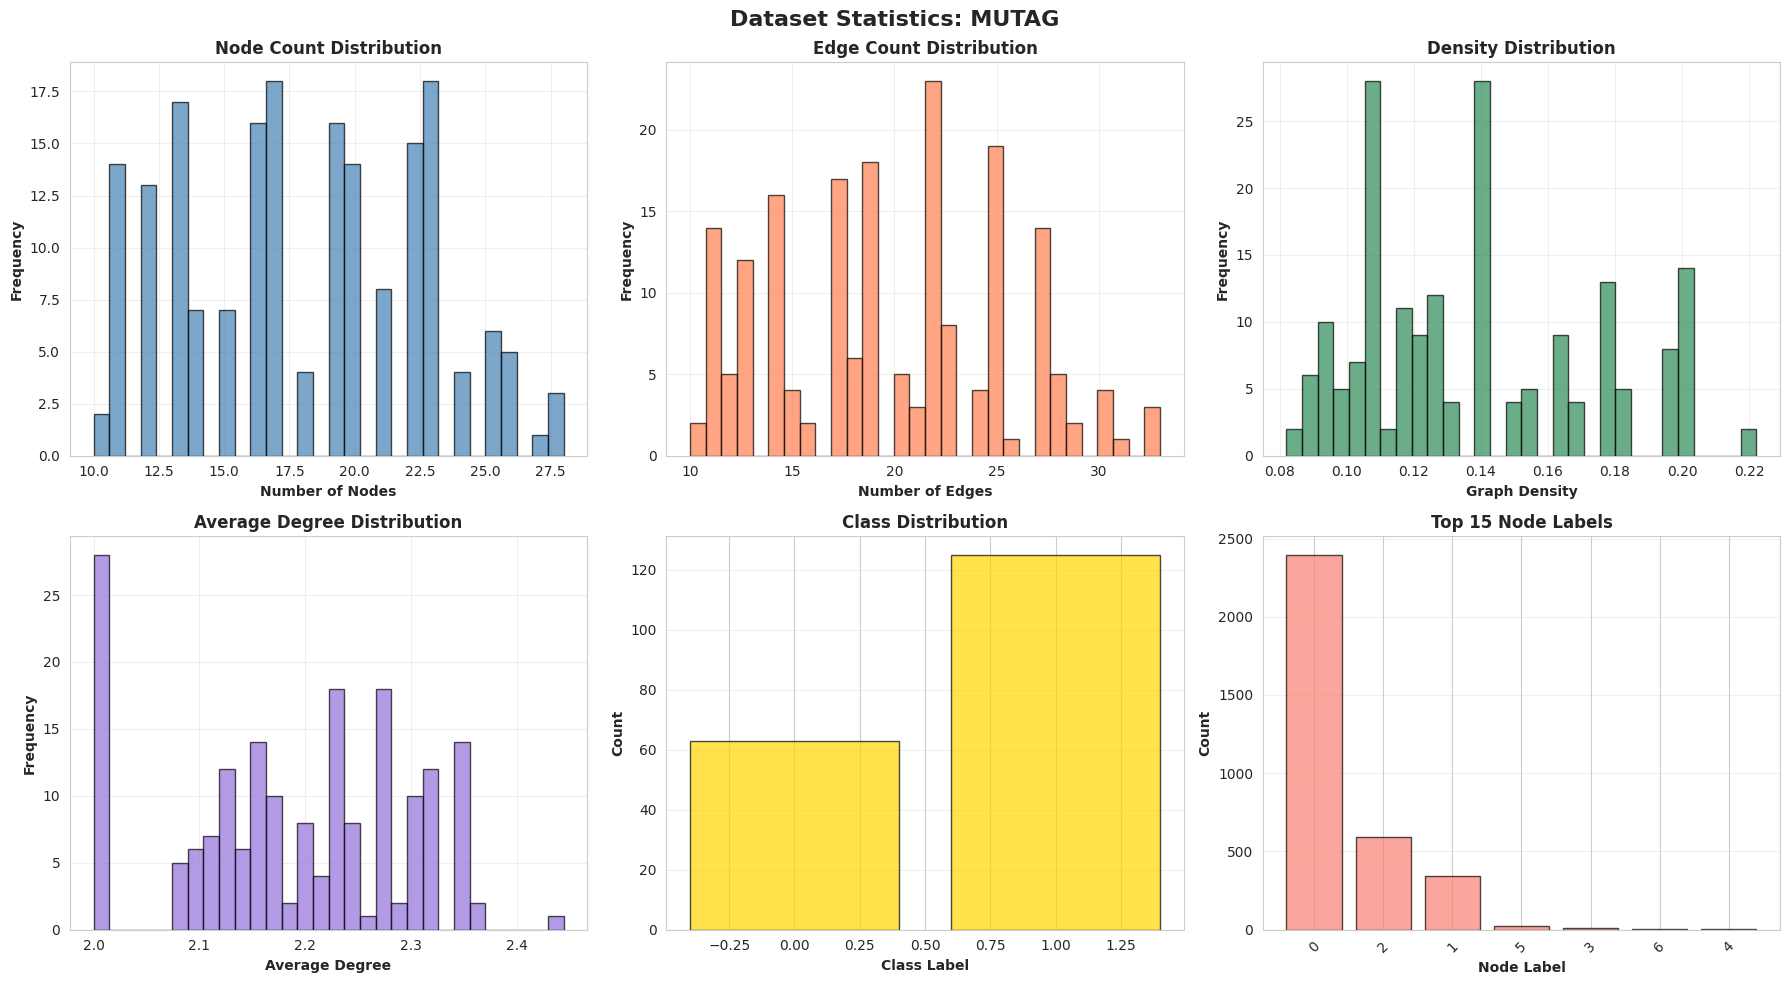

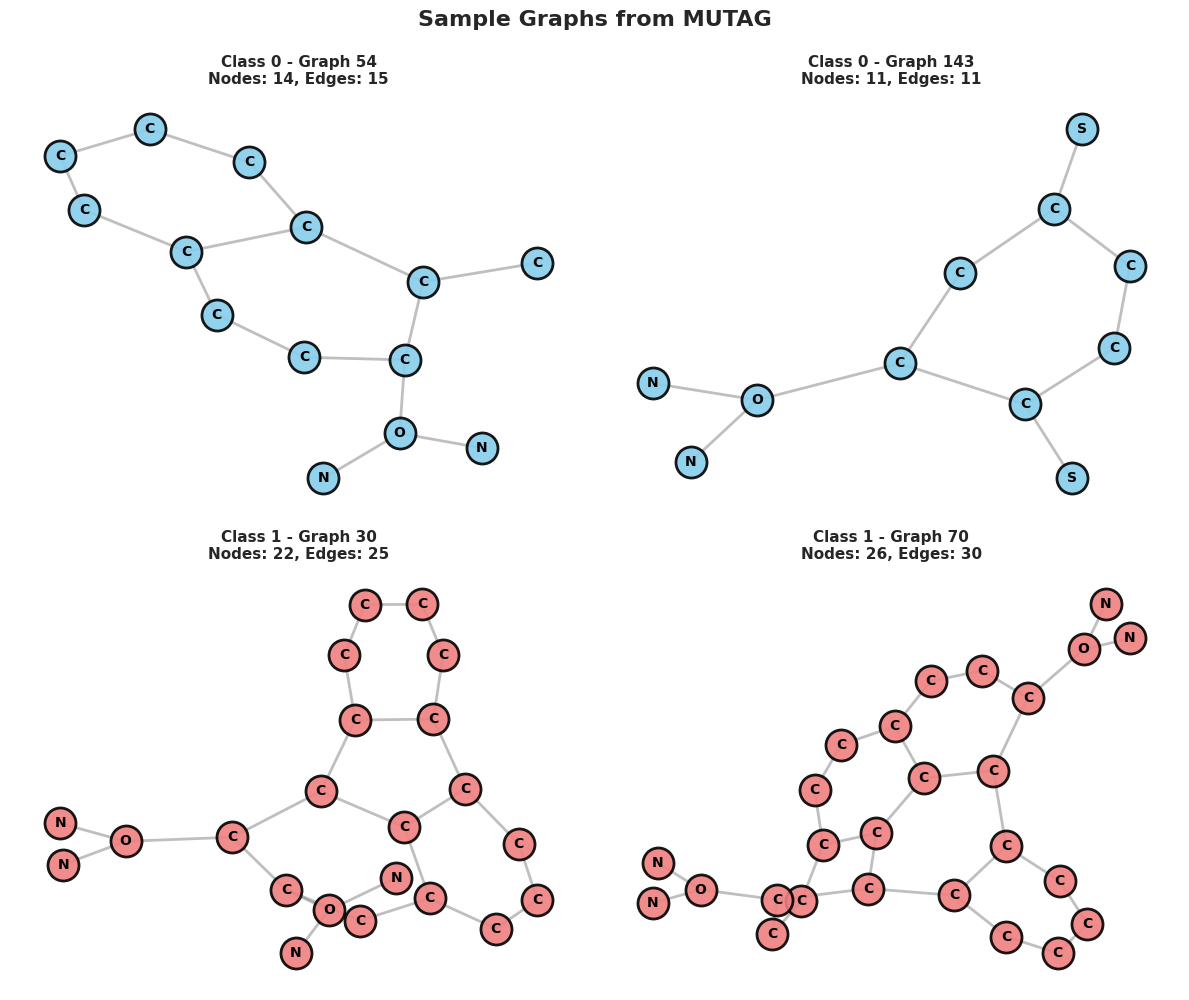

✓ EDA complete for MUTAG

PROCESSING DATASET: PTC_MR
✓ PTC_MR downloaded and extracted
✓ Loaded 344 graphs from PTC_MR
  Class distribution: Counter({0: 192, 1: 152})
DATASET STATISTICS: PTC_MR
Number of graphs: 344
Class distribution: Counter({0: 192, 1: 152})

Graph size statistics:
  Nodes - Mean: 14.29, Std: 9.02, Min: 2, Max: 64
  Edges - Mean: 14.69, Std: 10.05, Min: 1, Max: 71
  Density - Mean: 0.214, Std: 0.131

Node label distribution: {0: 1, 1: 23, 2: 693, 3: 368, 4: 29, 5: 3372, 6: 273, 7: 89, 8: 45, 9: 10, 10: 1, 11: 2, 12: 1, 13: 3, 14: 1, 15: 2, 16: 1, 17: 1}
Number of unique node labels: 18



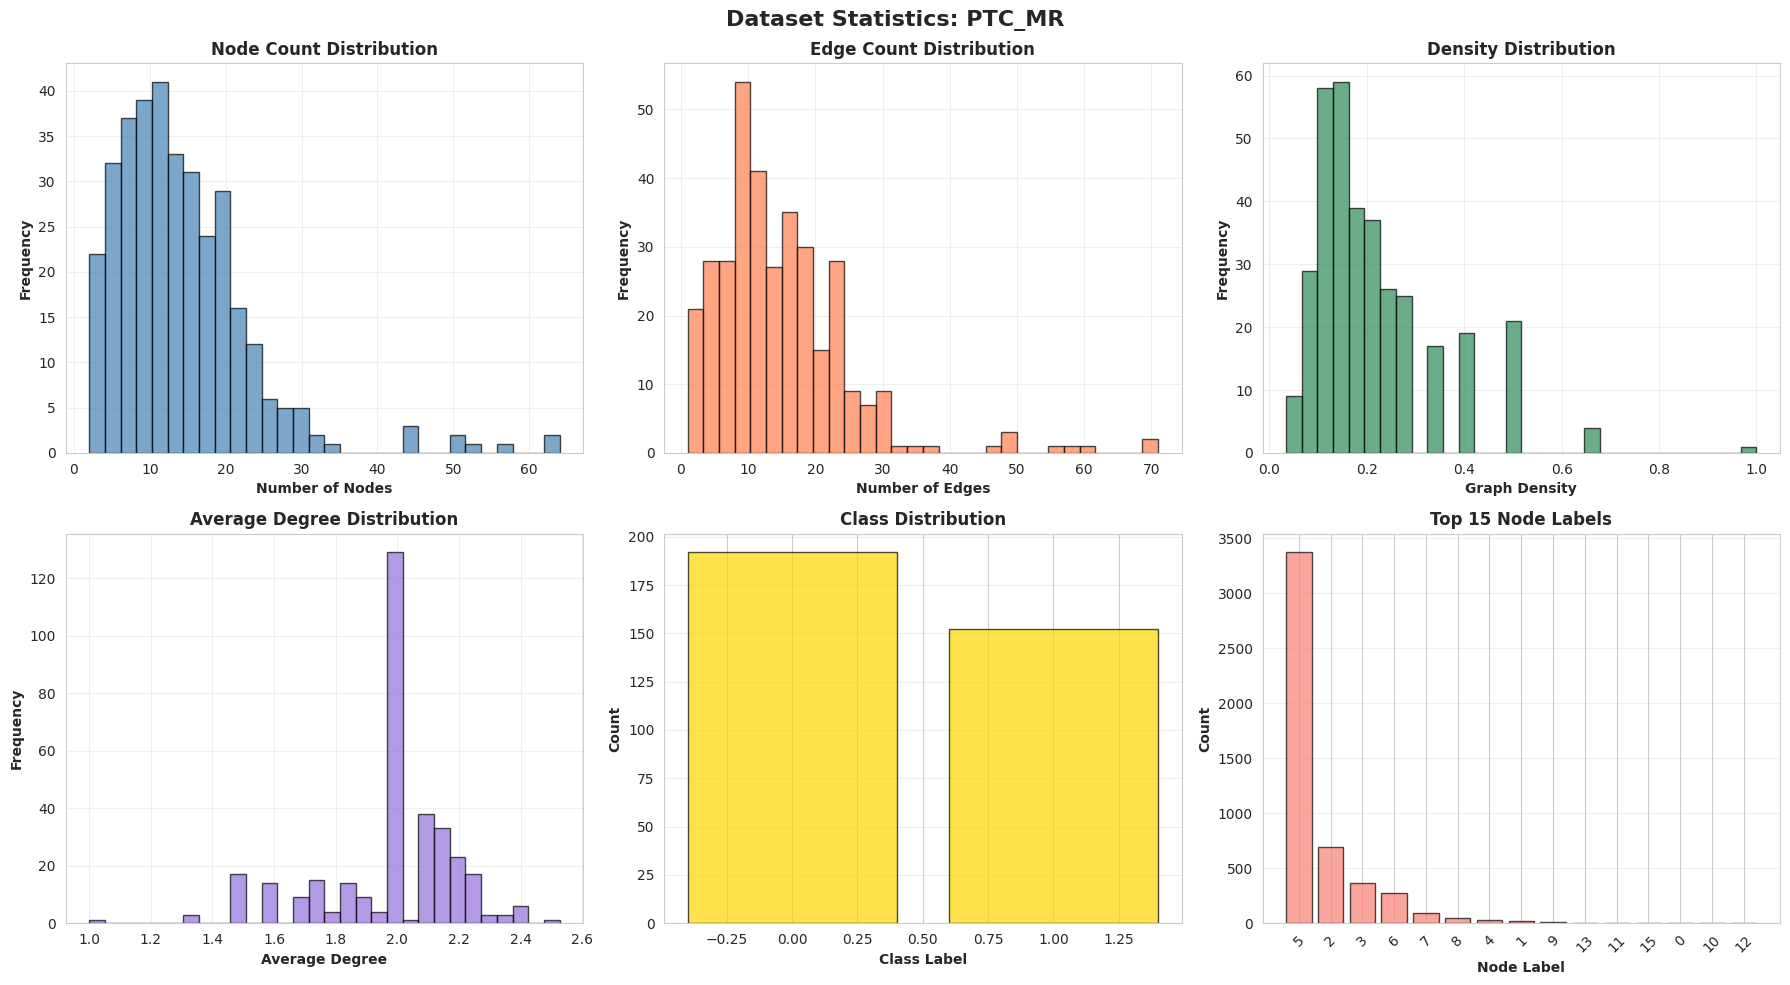

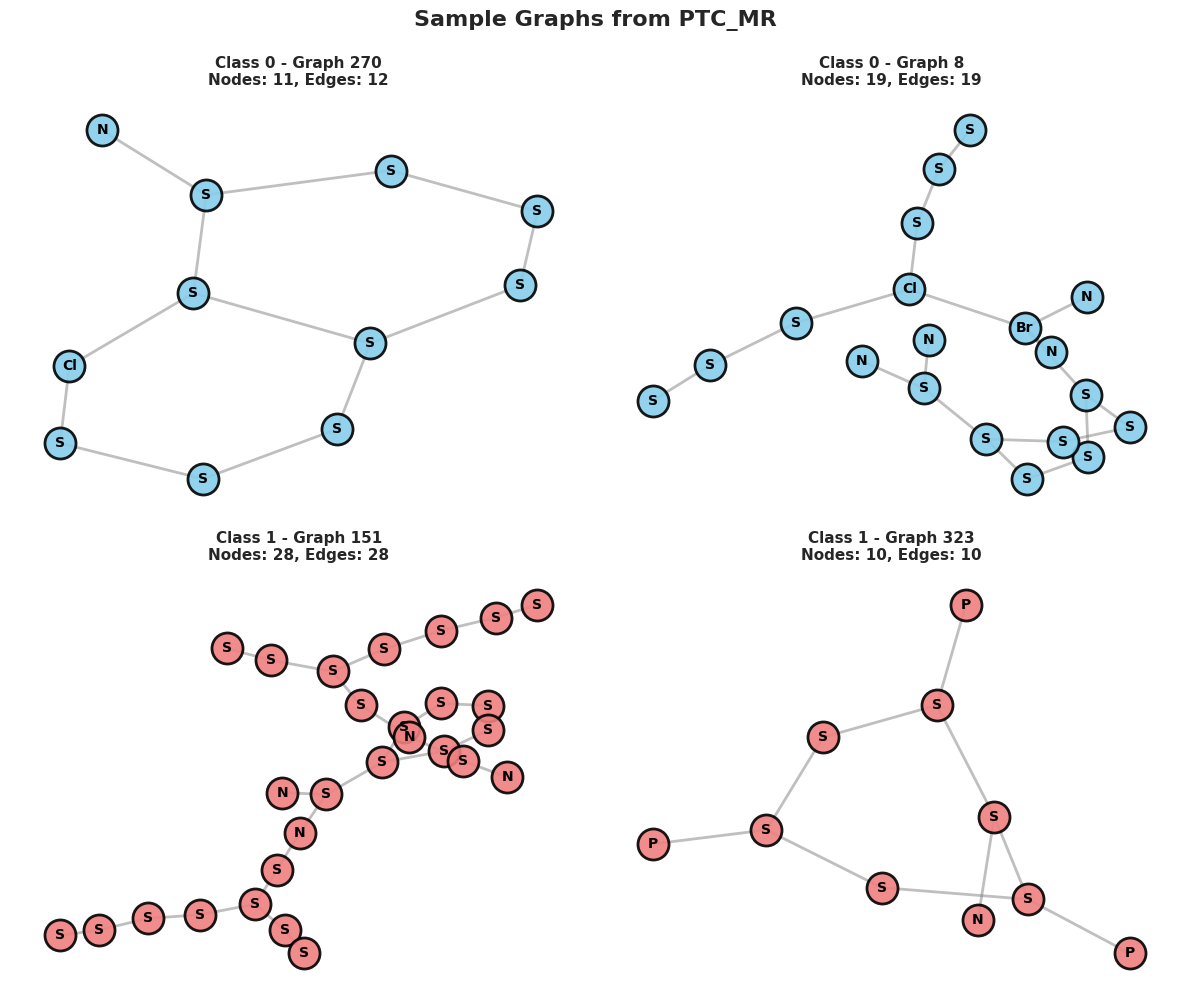

✓ EDA complete for PTC_MR

PROCESSING DATASET: PROTEINS
✓ PROTEINS downloaded and extracted
✓ Loaded 1113 graphs from PROTEINS
  Class distribution: Counter({0: 663, 1: 450})
DATASET STATISTICS: PROTEINS
Number of graphs: 1113
Class distribution: Counter({0: 663, 1: 450})

Graph size statistics:
  Nodes - Mean: 39.06, Std: 45.76, Min: 4, Max: 620
  Edges - Mean: 72.82, Std: 84.60, Min: 5, Max: 1049
  Density - Mean: 0.212, Std: 0.198

Node label distribution: {0: 21151, 1: 20931, 2: 1389}
Number of unique node labels: 3



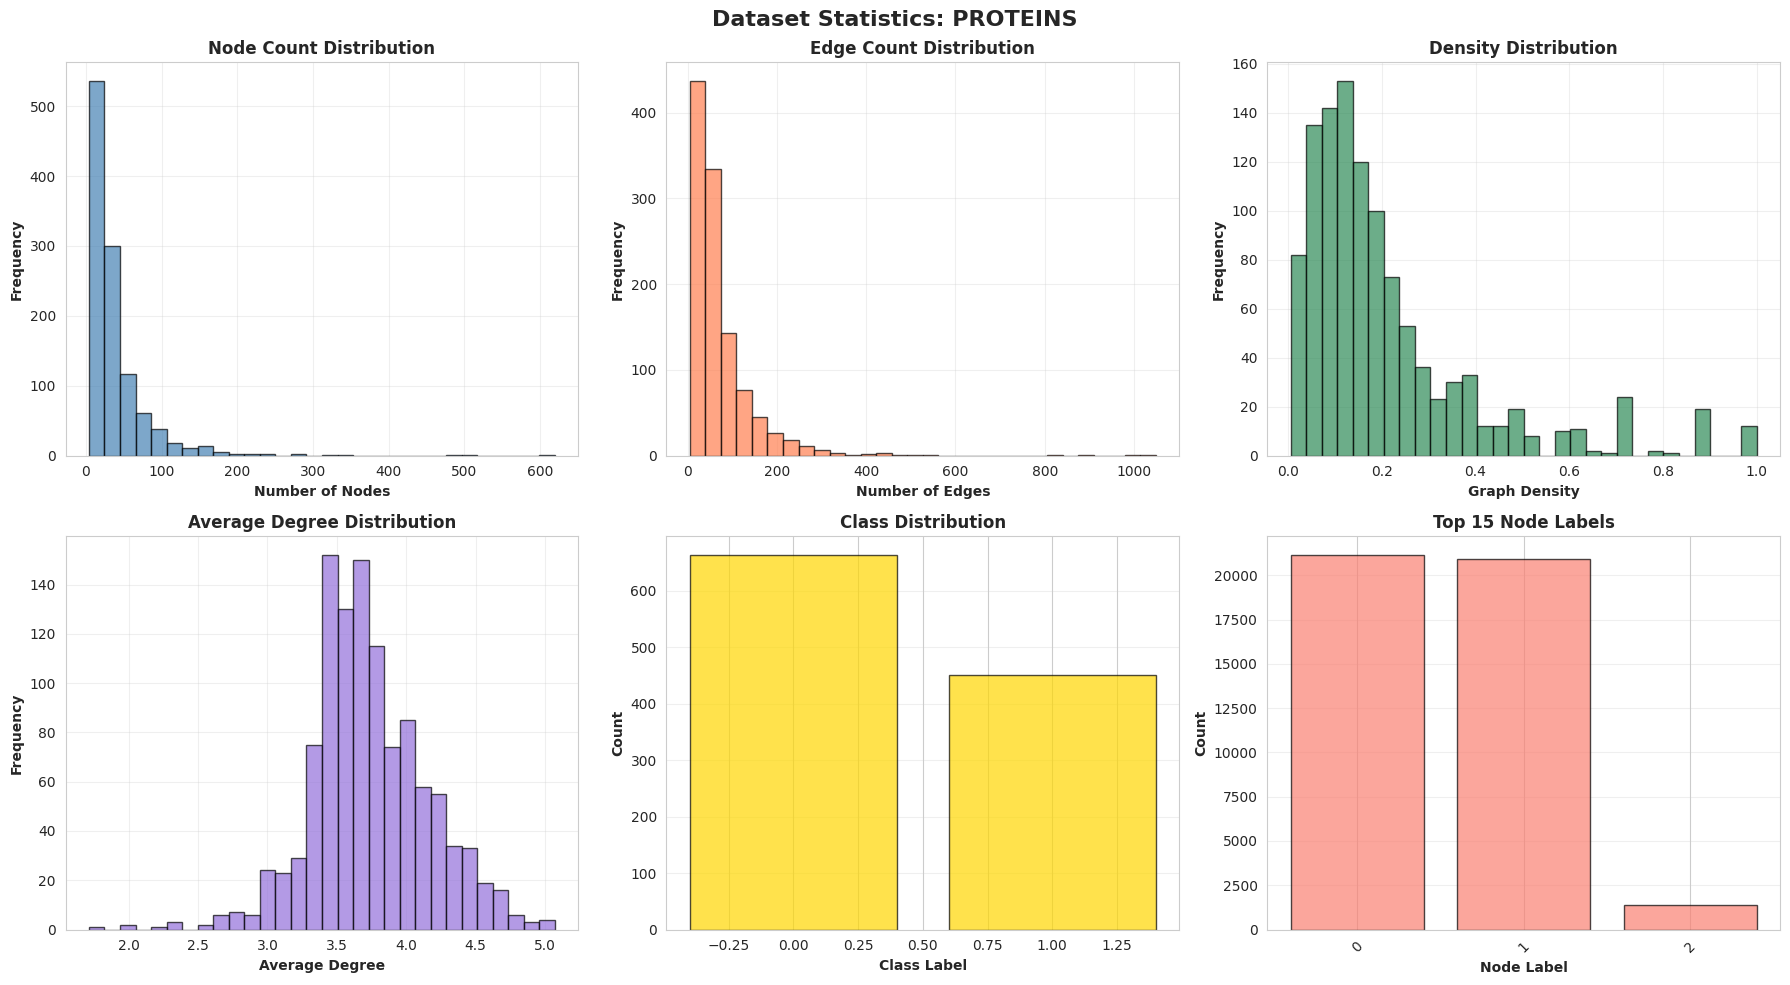

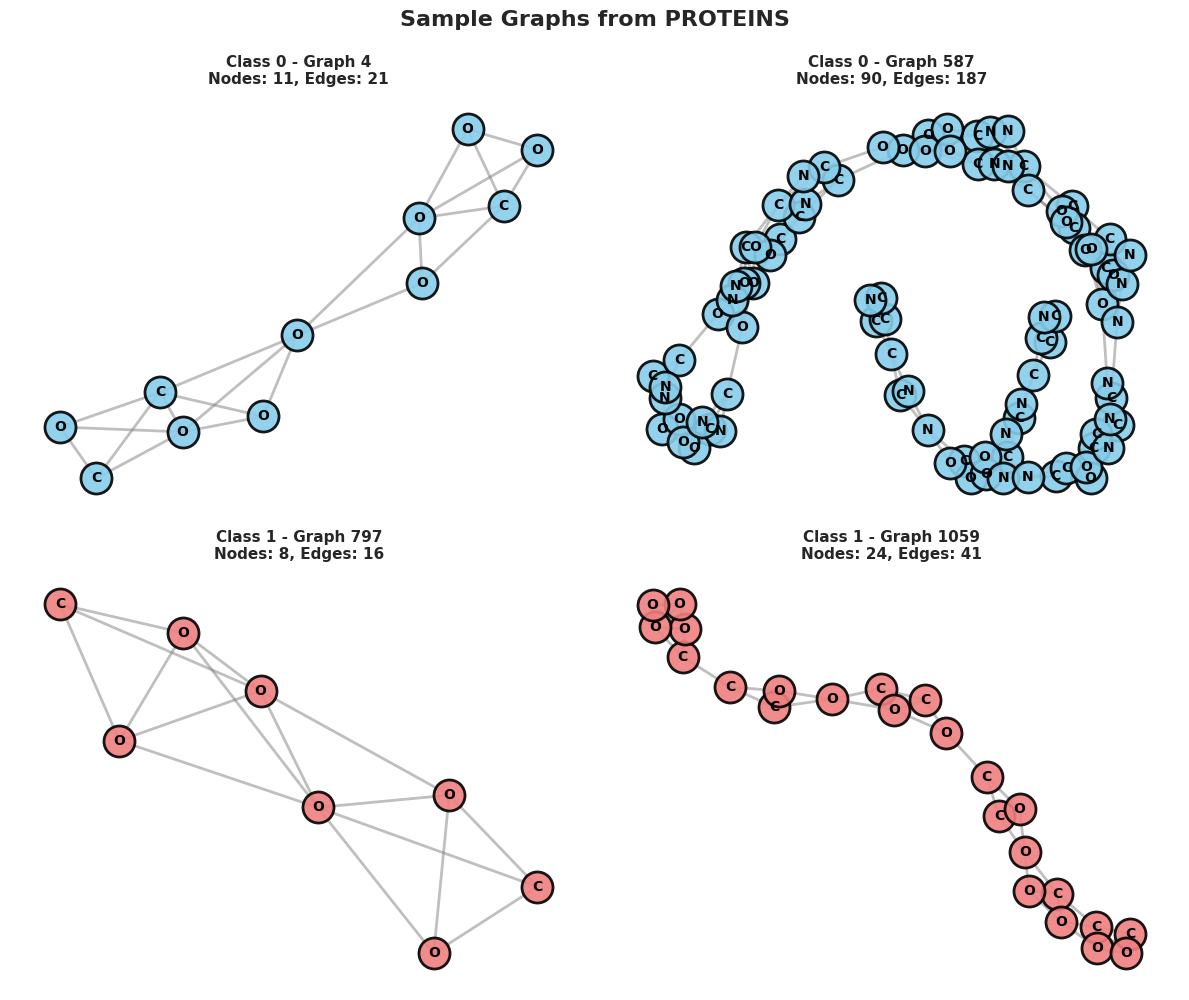

✓ EDA complete for PROTEINS

PROCESSING DATASET: NCI1
✓ NCI1 downloaded and extracted
✓ Loaded 4110 graphs from NCI1
  Class distribution: Counter({1: 2057, 0: 2053})
DATASET STATISTICS: NCI1
Number of graphs: 4110
Class distribution: Counter({1: 2057, 0: 2053})

Graph size statistics:
  Nodes - Mean: 29.87, Std: 13.56, Min: 3, Max: 111
  Edges - Mean: 32.30, Std: 14.93, Min: 2, Max: 119
  Density - Mean: 0.089, Std: 0.038

Node label distribution: {1: 18267, 2: 10279, 3: 90287, 4: 1275, 5: 1250, 6: 123, 7: 730, 8: 19, 9: 79, 10: 13, 11: 6, 12: 6, 13: 2, 14: 243, 15: 4, 16: 2, 17: 8, 18: 5, 19: 2, 20: 4, 21: 66, 22: 30, 23: 1, 24: 1, 25: 4, 26: 10, 27: 11, 28: 2, 29: 9, 30: 2, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1}
Number of unique node labels: 37



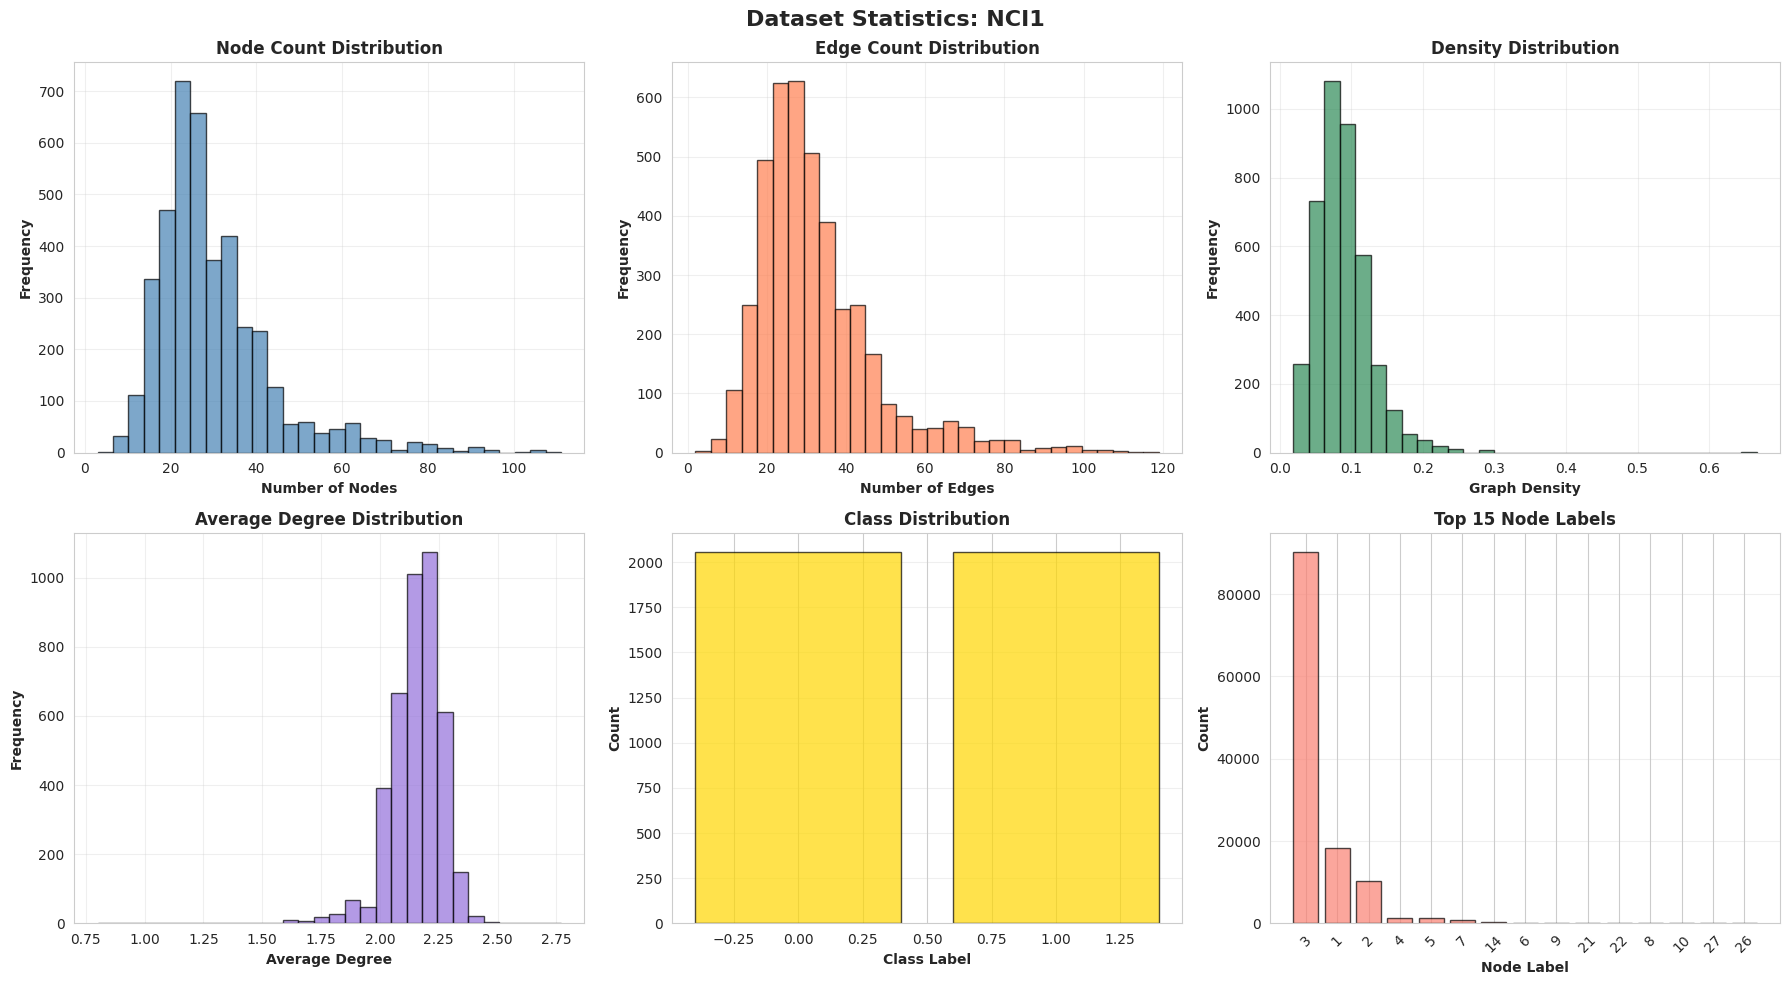

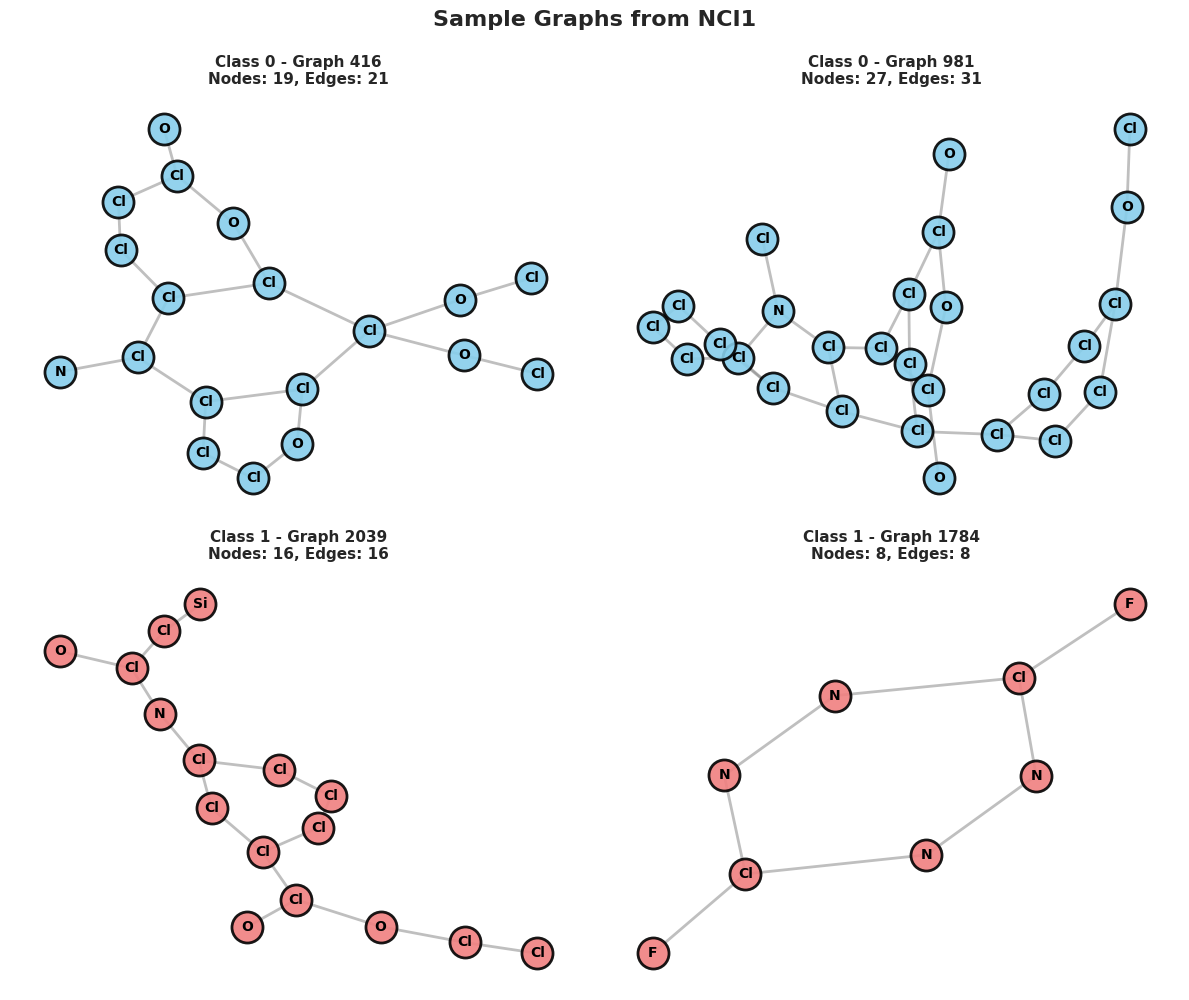

✓ EDA complete for NCI1

PROCESSING DATASET: AIDS
✓ AIDS downloaded and extracted
✓ Loaded 2000 graphs from AIDS
  Class distribution: Counter({1: 1600, 0: 400})
DATASET STATISTICS: AIDS
Number of graphs: 2000
Class distribution: Counter({1: 1600, 0: 400})

Graph size statistics:
  Nodes - Mean: 15.69, Std: 13.69, Min: 2, Max: 95
  Edges - Mean: 16.20, Std: 15.01, Min: 1, Max: 103
  Density - Mean: 0.194, Std: 0.081

Node label distribution: {0: 19564, 1: 5492, 2: 4149, 3: 385, 4: 78, 5: 1253, 6: 16, 7: 109, 8: 60, 9: 42, 10: 19, 11: 103, 12: 4, 13: 27, 14: 1, 15: 5, 16: 7, 17: 14, 18: 13, 19: 3, 20: 6, 21: 7, 22: 1, 23: 4, 24: 1, 25: 1, 26: 3, 27: 2, 28: 1, 29: 1, 30: 1, 31: 2, 32: 2, 33: 3, 34: 1, 35: 2, 36: 2, 37: 1}
Number of unique node labels: 38



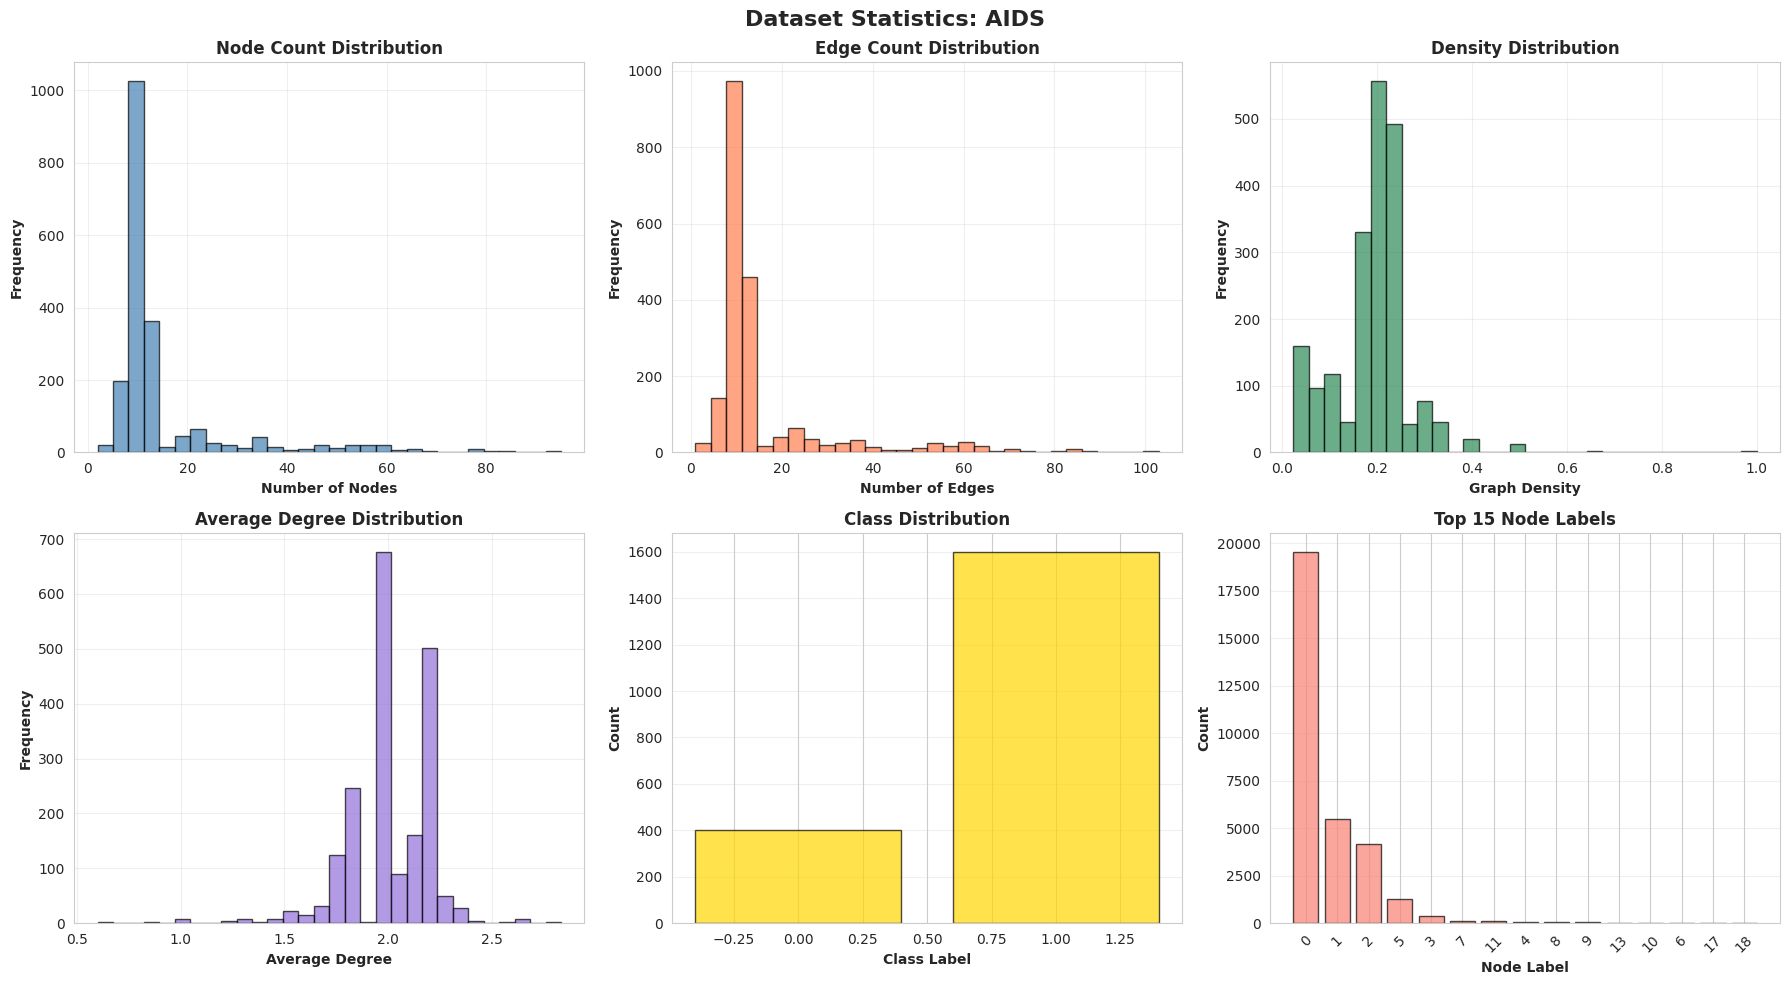

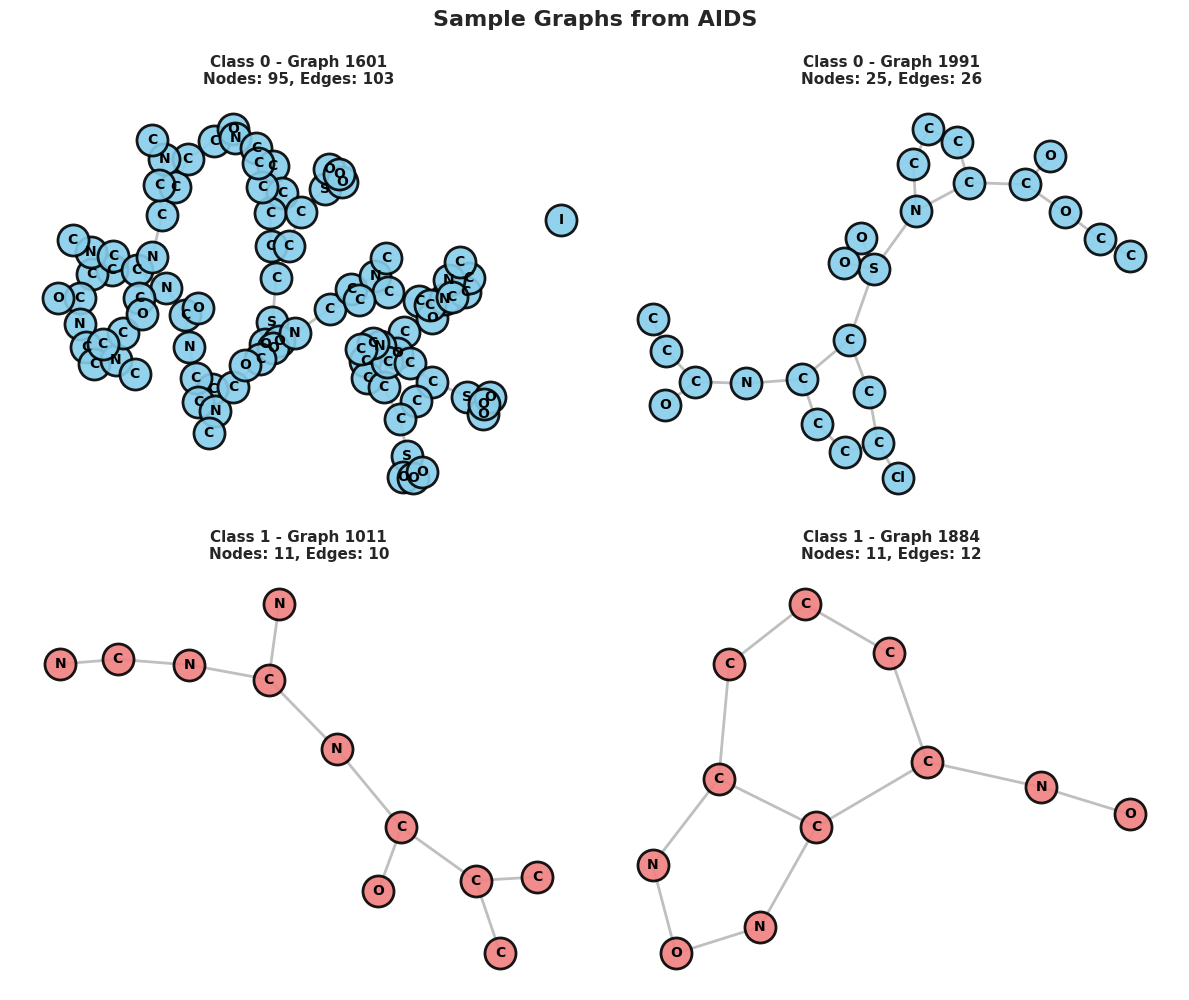

✓ EDA complete for AIDS

{'='*80}
✓ All datasets processed!
{'='*80}


In [5]:
# List of datasets
DATASETS = ['MUTAG', 'PTC_MR', 'PROTEINS', 'NCI1', 'AIDS']

# Run EDA for each dataset
for dataset_name in DATASETS:
    print(f"\n{'='*80}")
    print(f"PROCESSING DATASET: {dataset_name}")
    print(f"{'='*80}")

    # Load data
    graphs, labels = loader.load_graphs(dataset_name)

    if graphs is None or labels is None:
        print(f"✗ Failed to load {dataset_name}")
        continue

    # Analysis
    analyze_dataset(graphs, labels, dataset_name)

    # Statistics plots
    plot_dataset_statistics(graphs, labels, dataset_name)

    # Sample graphs
    visualize_sample_graphs(graphs, labels, n_samples=2, dataset_name=dataset_name)

    print(f"✓ EDA complete for {dataset_name}")

print("\n{'='*80}")
print("✓ All datasets processed!")
print("{'='*80}")

## 5. Summary

This notebook provides a complete EDA pipeline for the specified graph datasets. Key insights include:
- **Graph sizes** vary significantly across datasets (e.g., NCI1 has larger graphs).
- **Class balance** is generally reasonable but check for MUTAG/PTC-MR.
- **Node labels** correspond to atom types in molecular datasets.
- Sample visualizations help understand structural differences between classes.

For further analysis, consider computing graph invariants or running models.